In [1]:
from functions import *
from functions_new import *

import numpy as np
import os 

import matplotlib.pylab as plt
import matplotlib.patches as patches
from matplotlib.patches import Circle
from matplotlib.collections import LineCollection


import seaborn as sns
from seaborn import heatmap
from seaborn import kdeplot

from sklearn.decomposition import PCA
import hdbscan
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.signal import savgol_filter

import SOAPify
from SOAPify import SOAPclassification, calculateTransitionMatrix, normalizeMatrixByRow, getSOAPSettings
import SOAPify.HDF5er as HDF5er

In [2]:
XYZ_DIR = './input_hdf5/'
XYZ_OUTDIR = './output/211_600/'
NAME = '211_600' # NAME.hdf5
GROUP = "/Trajectories/"+NAME
MASK = True #be sure that mask used to create .hdf5 is the same used here
LOAD_LENS = False
LOAD_SOAP = False

XYZ_ORIG = [-30.393516, -10.20405, -10.0]
COFF=6  #be sure that is the same coff used to create soaps and lenses
window_length=20
wantedTrajectory = slice(0, None, None)


In [3]:
if MASK:
    HDF5_TRJ  = NAME + "mask.hdf5"
    HDF5_TRJ_nomask  = NAME + ".hdf5"
    with h5py.File(XYZ_DIR + HDF5_TRJ, "r") as trajFile:
        tgroup = trajFile[GROUP]
        universe = HDF5er.createUniverseFromSlice(tgroup, wantedTrajectory)
else:
    HDF5_TRJ  = NAME + ".hdf5"
    HDF5_TRJ_nomask  = NAME + ".hdf5"
    with h5py.File(XYZ_DIR + HDF5_TRJ, "r") as trajFile:
        tgroup = trajFile[GROUP]
        universe = HDF5er.createUniverseFromSlice(tgroup, wantedTrajectory)

In [4]:
nAtoms = len(universe.atoms)
windowToUSE = slice(window_length // 2, -window_length // 2)
windowToUSE_last = slice(window_length // 2, -(window_length // 2+1))

# SOAP

### Read soap input

In [5]:
if LOAD_SOAP:
    v_soap = np.load(XYZ_DIR+'X_normalized.npz')['name1'][:-1][windowToUSE]
    print(np.shape(v_soap))
else:
    
    mycwd = os.getcwd()
    os.chdir(XYZ_DIR)
    prepareSOAP(HDF5_TRJ_nomask, NAME, COFF)
    os.chdir(mycwd)

    if MASK:
        with h5py.File(XYZ_DIR+NAME+'.hdf5', 'r') as f:
            mask = f[GROUP+"Trajectory"][0, :, 2] > 12
        
        with h5py.File(XYZ_DIR+NAME+'soap.hdf5', 'r') as f:
            ds = f["SOAP/"+NAME]
            fillSettings = getSOAPSettings(ds)
            X = ds[:][:, mask]
        
    else: 
        with h5py.File(XYZ_DIR+NAME+'soap.hdf5', 'r') as f:
            ds = f["SOAP/"+NAME]
            fillSettings = getSOAPSettings(ds)
            X = ds[:, :, :]

    X = SOAPify.fillSOAPVectorFromdscribe(
            X[:], **fillSettings)
        

    X = SOAPify.normalizeArray(X)
    np.savez(XYZ_DIR+'X_normalized.npz', name1=X)
    
    v_soap = np.load(XYZ_DIR+'X_normalized.npz')['name1'][:-1][windowToUSE]
    print(np.shape(v_soap))

(481, 900, 576)


In [6]:
v_soap_fl = np.array(v_soap).reshape(np.shape(v_soap)[0]*np.shape(v_soap)[1],np.shape(v_soap)[2])
np.shape(v_soap_fl)

(432900, 576)

### PCA and clustering

In [90]:
pca = PCA(n_components=4)
pc_soap = pca.fit_transform(v_soap_fl)
pca.explained_variance_ratio_.cumsum()

array([0.80014596, 0.98359084, 0.99412915, 0.99645239])

In [91]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=80, cluster_selection_method='eom',prediction_data=True)
clusterer.fit(pc_soap)
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
clusters = np.array([np.argmax(x) for x in soft_clusters])

In [93]:
data_cl = {}
for i in range(np.max(clusters)+1):
    data_cl[i] = {}
    data_cl[i]["elements"] = pc_soap[clusters == i]
    data_cl[i]["min"] = np.min(data_cl[i]["elements"])
    data_cl[i]["max"] = np.max(data_cl[i]["elements"])

In [94]:
palette = sns.color_palette('tab20', n_colors=np.max(clusters)+1)
cluster_colors = [palette[x] for x in clusters]
#palette = ['gray','gray','gray','gray','gray','gray','gray']

In [95]:
sns.color_palette(palette)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)]

/users_home/mcrippa/Joint_SOAP/functions_new.py:73: RuntimeWarning: divide by zero encountered in log
  lh = numpy.log(h)


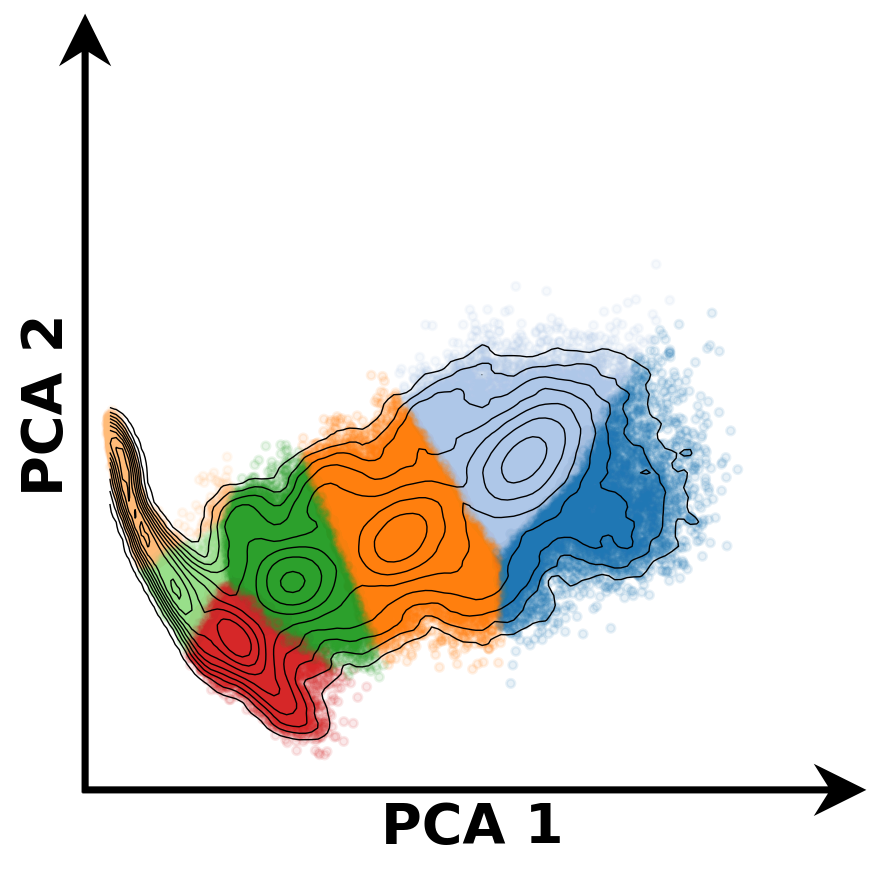

In [96]:
Xpc = 0
Ypc = 1

_, ax = plt.subplots(1, figsize=(5,5), dpi=200)

ax.scatter(pc_soap[:,Xpc],pc_soap[:,Ypc], c=np.array(palette)[clusters], marker='.', alpha=0.1)
lh, Xe, Ye, lhmin = getDensity(pc_soap, Xpc, Ypc, 100)
levels = 10
cont = ax.contour(Xe,
    Ye,
    lh,
    colors="k",
    linewidths=0.5,
    levels=levels,
    antialiased=True,
    linestyles="solid",
    vmin=lhmin,
    vmax=0,
)

ax.set_xlim((-0.1,0.4))
ax.set_ylim((-0.17214253822158188, 0.3356265130498729))
for side in ['bottom','right','top','left']:
    ax.spines[side].set_linewidth(2)


ax.set_xlabel('PCA 1', weight='bold',size=20)
ax.set_ylabel('PCA 2', weight='bold',size=20)
for side in ['right','top','left','bottom']:
    ax.spines[side].set_visible(False)

ax.tick_params(
axis='both',          # changes apply to the x-axis
which='major',      # both major and minor ticks are affected
bottom=False,
left=False,      
labelleft=False,
labelbottom=False) 
annots = arrowed_spines(ax, locations=('bottom right', 'left up')) 

In [97]:
#tmp_slice = slice(None,-1,None)    
reshaped_labels = prepareData(clusters.reshape(np.shape(v_soap)[0],np.shape(v_soap)[1]))
export(XYZ_OUTDIR+NAME+'SOAP.xyz', XYZ_DIR+HDF5_TRJ, windowToUSE_last , GROUP, XYZ_ORIG, reshaped_labels) 

### Transition matrix


In [98]:
minmax = [[cname, data["max"]] for cname, data in data_cl.items()]
minmax = sorted(minmax, key=lambda x: x[1])

In [99]:
order = {   0 : 3,
            1 : 5,
            2 : 6,
            3 : 4,
            4 : 2,
            5 : 1,
            6 : 0}

palette = sns.color_palette('tab20', n_colors=np.max(list(np.squeeze(clusters)))+1)
palette_s = list()
for i,v in enumerate(list(order.values())):
    palette_s.append(palette[v])

palette = sns.color_palette(palette_s)

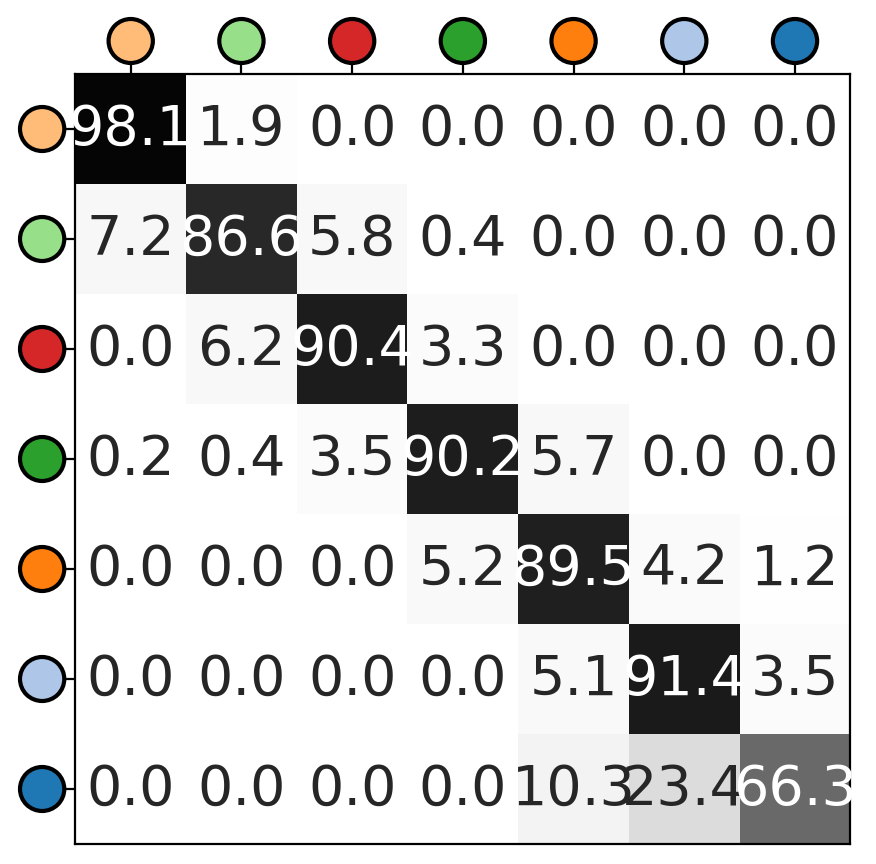

In [100]:
classifications = SOAPclassification(
    [], prepareData(reshaped_labels), [f"C{int(m[0])}" for m in np.sort(minmax, axis=0)]
)
tmat = calculateTransitionMatrix(classifications)
tmat = normalizeMatrixByRow(tmat)*100
tmat = tmat[:, list(order.values())]
tmat = tmat[ list(order.values()),:]


_, ax = plt.subplots(1,figsize=(5,5), dpi=200)
heatmap(
    tmat,
    fmt='.1f',
    vmax=100,
    vmin=0,
    cmap="Greys",
    annot=True,
    annot_kws={"fontsize": 20},
    xticklabels=classifications.legend,
    yticklabels=classifications.legend,
    cbar=False,
    ax=ax,
)

for i, label in enumerate(classifications.legend):
    ax.add_patch(
        Circle(
            (0.5 + i, -0.3),
            facecolor=palette[i],
            lw=1.5,
            edgecolor="black",
            radius=0.2,
            clip_on=False,
        )
    )
    ax.add_patch(
        Circle(
            (-0.3, 0.5 + i),
            facecolor=palette[i],
            lw=1.5,
            edgecolor="black",
            radius=0.2,
            clip_on=False,
        )
    )

    for _, spine in ax.spines.items():
        spine.set_visible(True)

    ax.get_xaxis().set_ticklabels([])
    ax.xaxis.tick_top()
    ax.set_xticklabels([])
    ax.set_yticklabels([])

/tmp/ipykernel_2062760/1186475120.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels([1], fontsize=18)


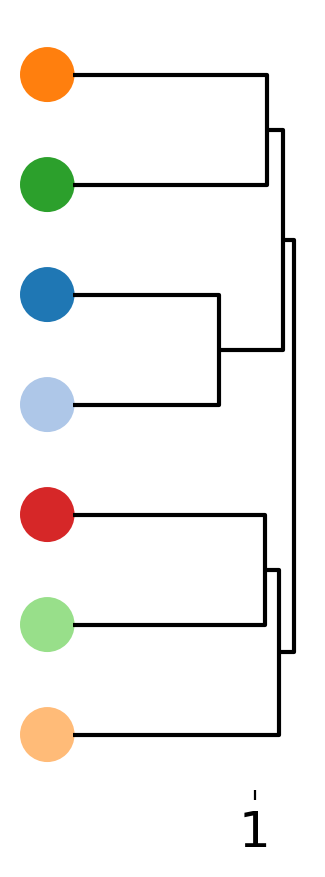

In [109]:
#palette = sns.color_palette('tab20', n_colors=np.max(clusters)+1)
cM = pdist(tmat, 'correlation')
Z = linkage(cM, method='average')
fig, ax = plt.subplots(figsize=(1.5, 5), dpi=200)
dn = dendrogram(Z,orientation='right',distance_sort='ascending', color_threshold=0, above_threshold_color='black', ax=ax)


TICKYPOS = -0.14
tickslabels = [i*10+5 for i in range(len(tmat))]

for i in range(len(tmat)):
    ax.add_patch(patches.Ellipse((TICKYPOS,tickslabels[i]), 0.3,5, facecolor=palette[dn['leaves'][i]], lw=1,
                  edgecolor=None, clip_on=False))


#ax.set_xticklabels([])
ax.set_yticklabels([])
_ = ax.set_xticklabels([1], fontsize=18)
_ = ax.set_xticks([1])
for _, spine in ax.spines.items():
    spine.set_visible(False)

plt.savefig('dendro.svg')

### Dendrogram cutting

In [18]:
mapping = { 0 : [0,1],
            1 : [2],
            2 : [3],
            3 : [4],
            4 : [5],
            5 : [6]}

In [19]:
new_dic = {}
for k,v in mapping.items():
    for x in v:
        new_dic.setdefault(x,[]).append(k)

In [20]:
replacer = new_dic.get  # For faster gets.
clusters_dn = np.squeeze(np.array([replacer(n, n) for n in clusters]))
palette = sns.color_palette('turbo', n_colors=np.max(list(np.squeeze(clusters_dn)))+1)
cluster_colors = [palette[x] for x in list(np.squeeze(clusters_dn))]
palette


[(0.27698, 0.46153, 0.93309),
 (0.10738, 0.81381, 0.83484),
 (0.38127, 0.98909, 0.42386),
 (0.82333, 0.91253, 0.20663),
 (0.99672, 0.60977, 0.17842),
 (0.8538, 0.2217, 0.02677)]

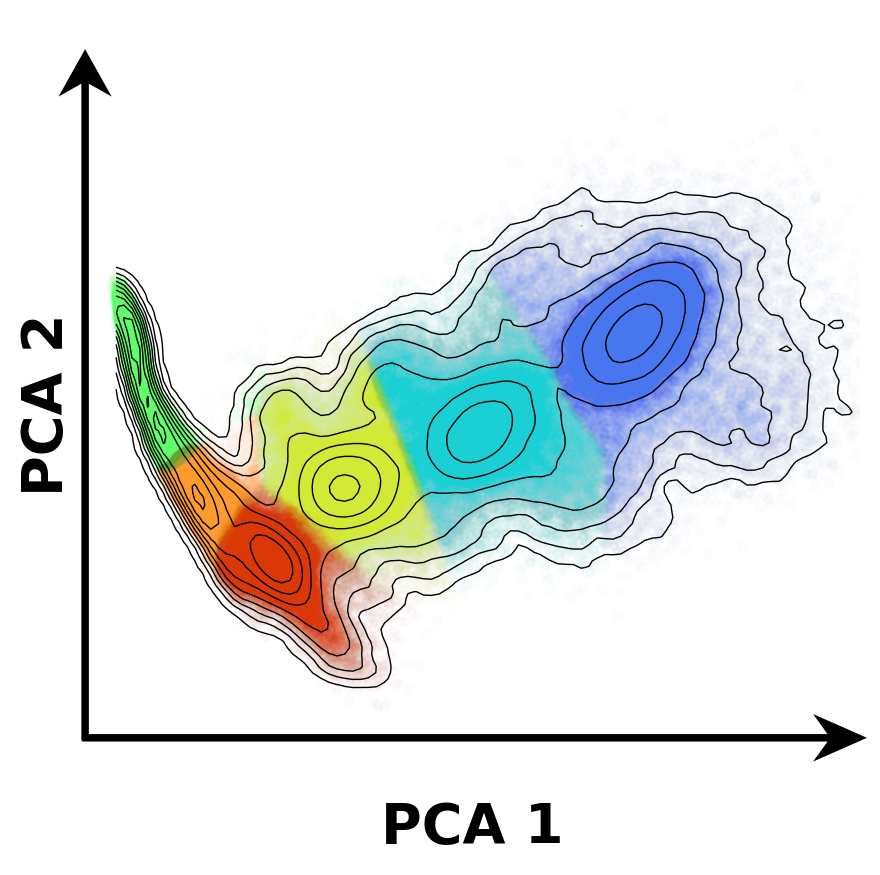

In [21]:
Xpc = 0
Ypc = 1

_, ax = plt.subplots(1, figsize=(5,5), dpi=200)

ax.scatter(pc_soap[:,Xpc],pc_soap[:,Ypc], c=np.array(palette)[clusters_dn], marker='.', alpha=0.01)
lh, Xe, Ye, lhmin = getDensity(pc_soap, Xpc, Ypc, 100)
levels = 10
cont = ax.contour(Xe,
    Ye,
    lh,
    colors="k",
    linewidths=0.5,
    levels=levels,
    antialiased=True,
    linestyles="solid",
    vmin=lhmin,
    vmax=0,
)

ax.set_xlim((-0.1,0.3))

for side in ['bottom','right','top','left']:
    ax.spines[side].set_linewidth(2)


ax.set_xlabel('PCA 1', weight='bold',size=20)
ax.set_ylabel('PCA 2', weight='bold',size=20)
for side in ['right','top','left','bottom']:
    ax.spines[side].set_visible(False)

ax.tick_params(
axis='both',          # changes apply to the x-axis
which='major',      # both major and minor ticks are affected
bottom=False,
left=False,      
labelleft=False,
labelbottom=False) 
annots = arrowed_spines(ax, locations=('bottom right', 'left up')) 

In [22]:
reshaped_labels = prepareData(clusters_dn.reshape(np.shape(v_soap)[0],np.shape(v_soap)[1]))
export(XYZ_OUTDIR+NAME+'SOAP_macro.xyz',  XYZ_DIR+HDF5_TRJ, windowToUSE_last, GROUP, XYZ_ORIG, reshaped_labels)

In [23]:
data_cl = {}
for i in range(np.max(clusters_dn)+1):
    data_cl[i] = {}
    data_cl[i]["elements"] = pc_soap[clusters_dn == i]
    data_cl[i]["min"] = np.min(data_cl[i]["elements"])
    data_cl[i]["max"] = np.max(data_cl[i]["elements"])

In [24]:
minmax = [[cname, data["max"]] for cname, data in data_cl.items()]
minmax = sorted(minmax, key=lambda x: x[1])

In [25]:
order = {   0 : 2,
            1 : 4,
            2 : 5,
            3 : 3,
            4 : 1,
            5 : 0}

palette = sns.color_palette('turbo', n_colors=np.max(list(np.squeeze(clusters_dn)))+1)
palette_s = list()
for i,v in enumerate(list(order.values())):
    palette_s.append(palette[v])

palette = sns.color_palette(palette_s)

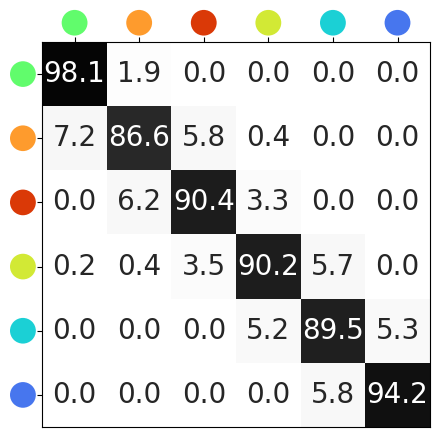

In [26]:
classifications = SOAPclassification(
    [], prepareData(reshaped_labels), [f"C{int(m[0])}" for m in np.sort(minmax, axis=0)]
)

tmat = calculateTransitionMatrix(classifications)
tmat = normalizeMatrixByRow(tmat)*100
tmat = tmat[:, list(order.values())]
tmat = tmat[ list(order.values()),:]

_, ax = plt.subplots(1, figsize=(5,5))
heatmap(
    tmat,
    fmt='.1f',
    vmax=100,
    vmin=0,
    cmap="Greys",
    annot=True,
    annot_kws={"fontsize": 20},
    xticklabels=classifications.legend,
    yticklabels=classifications.legend,
    cbar=False,
    ax=ax,
)

for i, label in enumerate(classifications.legend):
    ax.add_patch(
        Circle(
            (0.5 + i, -0.3),
            facecolor=palette[i],
            lw=1.5,
            edgecolor=None,
            radius=0.2,
            clip_on=False,
        )
    )
    ax.add_patch(
        Circle(
            (-0.3, 0.5 + i),
            facecolor=palette[i],
            lw=1.5,
            edgecolor=None,
            radius=0.2,
            clip_on=False,
        )
    )

    for _, spine in ax.spines.items():
        spine.set_visible(True)

    ax.get_xaxis().set_ticklabels([])
    ax.xaxis.tick_top()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.savefig('mat.svg')

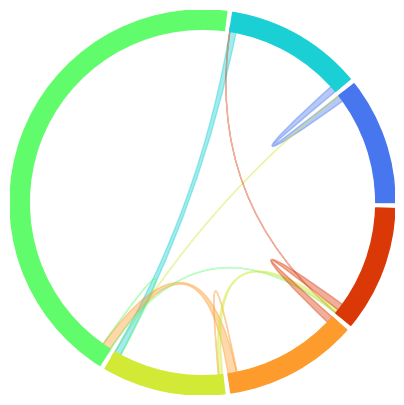

In [27]:
palette = sns.color_palette('turbo', n_colors=np.max(list(np.squeeze(clusters_dn)))+1)
tmat = calculateTransitionMatrix(classifications)
fig, ax = plt.subplots(1, figsize=(5, 5))

ChordDiagram(
    tmat,
    ax=ax,
    colors=palette.as_hex(),
    # labels=["0", "1", "2", "3", "4"],
    # width=0,
    onlyFlux=True,
    #GAP=10,
    ignoreLessThan=0.01,
    ordering="matrix",
    labelskwargs=dict(),
    visualizationScale=1)
plt.savefig('chord.svg')


# LENS

### Lens descriptor and filtering

In [110]:
if LOAD_LENS:
    LENS = np.load(XYZ_DIR+'lens.npy')
else:
    neigCounts = SOAPify.analysis.listNeighboursAlongTrajectory(universe, cutOff=COFF)
    LENS, nn, *_ = SOAPify.analysis.neighbourChangeInTime(neigCounts)
    np.save(XYZ_DIR+"lens", LENS)

In [111]:
LENS_fw = np.transpose(np.transpose(LENS)[1:])
atom = nAtoms - 1
savGolPrint = np.arange(LENS_fw[atom].shape[0])

In [112]:
polyorder = 2
filteredLENS = savgol_filter(
    LENS_fw, window_length=window_length, polyorder=polyorder, axis=-1
)

for frame in filteredLENS:
    frame[frame > 1] = 1
    frame[frame < 0] = 0

In [113]:
dataToFit = transposeAndFlatten(filteredLENS[:, windowToUSE])
print("minmax: ", np.min(dataToFit), np.max(dataToFit))

minmax:  0.0 0.9749964881650702


### Clustering

In [114]:
manualClustering=False

if manualClustering:
    
    cutoffs = [ 0.11662100535211521, 0.4238142750627305]

    chunk = [np.min(dataToFit)]+cutoffs+[np.max(dataToFit)+0.01]
    b_chunk = list()
    for c in range(len(chunk)-1):
        b_chunk.append([chunk[c],chunk[c+1]])

    cl_tot = list()
    particle = [i for i in range(nAtoms)]
    for p in particle:
        cl = list()
        for f_desc in filteredLENS[:, windowToUSE][p]:
            i=0
            for idx_bc,bc in enumerate(b_chunk):
                if check(f_desc,bc):
                    cl.append(idx_bc)
                    i+=1
        cl_tot.append(cl)
    
    trans_cl_tot = np.array(cl_tot).T
    clusters = np.reshape(trans_cl_tot, np.shape(trans_cl_tot)[0]*np.shape(trans_cl_tot)[1])
    
    bestnclusters = len(cutoffs)+1

else:
    bestnclusters = 3
    clusters = KMeans(bestnclusters, random_state=666).fit_predict(
        dataToFit.reshape(-1, 1)
    )

/users_home/mcrippa/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [115]:
data_KM = {}
for i in range(bestnclusters):
    data_KM[i] = {}
    data_KM[i]["elements"] = dataToFit[clusters == i]
    data_KM[i]["min"] = np.min(data_KM[i]["elements"])
    data_KM[i]["max"] = np.max(data_KM[i]["elements"])

In [116]:
classifiedFilteredLENS = classifying(filteredLENS[:, windowToUSE], data_KM)

In [117]:
palette = sns.color_palette("PuRd", bestnclusters)
palette

[(0.8310342176086121, 0.7243521722414455, 0.854317570165321),
 (0.8750019223375625, 0.3923875432525951, 0.6878585159554017),
 (0.8028604382929643, 0.0689273356401384, 0.33550173010380624)]

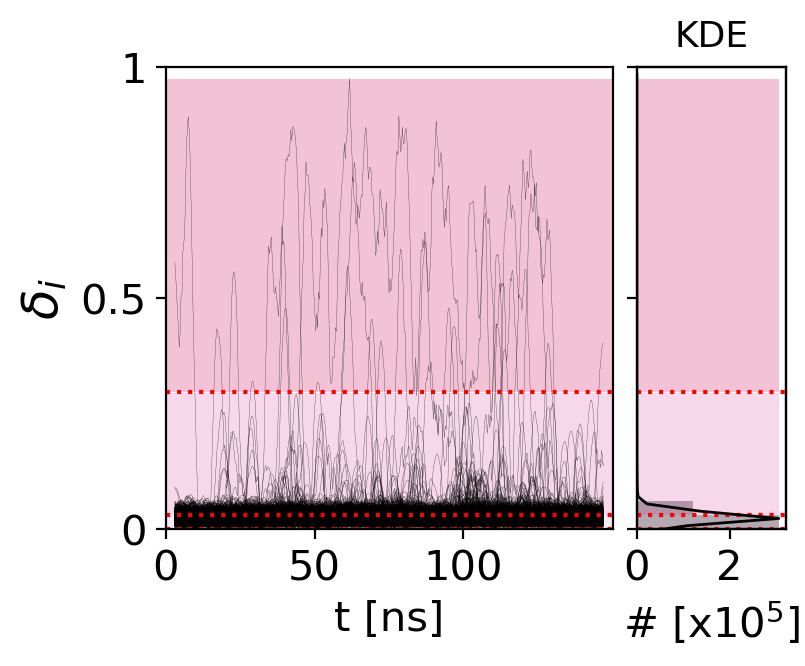

In [118]:
fig, axes = plt.subplots(
    1, 2, figsize=(4, 3), dpi=200, width_ratios=[3, 1], sharey=True
)

for flns in filteredLENS:
    axes[0].plot(
        savGolPrint[windowToUSE],
        flns[windowToUSE],
        color="k",
        linewidth=0.1,
        alpha=0.9,
    )
hist = axes[1].hist(
    dataToFit,
    alpha=0.7,
    color="gray",
    bins="doane",
    #density=True,
    orientation="horizontal",
)

axes[0].set_xlim(0, len(savGolPrint))
axes[0].set_xlabel(r't [ns]', size=15)
axes[0].set_xticks([0,50/3*10,100/3*10])
axes[0].set_xticklabels([0,50,100], fontsize=15)
axes[1].set_yticklabels([], size=15)
axes[1].set_yticks([], [])

axes[0].set_ylabel(r'$\delta_{i}$', size=18)
axes[0].set_yticks([0, 0.5, 1])
axes[0].set_yticklabels([0,0.5,1], fontsize=15)
axes[0].set_ylim((0,1))

axes[1].set_xlabel("# [x$10^5$]", size=15)
axes[1].set_xticks([0,2e5])
axes[1].set_xticklabels([0,2], size=15)

height = np.max(hist[0])
for cname, data in data_KM.items():
    # center = delta+data['min']
    bin_size = data["max"] - data["min"]
    for i, ax in enumerate(axes):
        ax.barh(
            y=data["min"],
            width=len(savGolPrint) if i == 0 else height,
            height=bin_size,
            align="edge",
            alpha=0.25,
            color=palette[cname],
            linewidth=1.5,
        )
        ax.axhline(y=data["min"], c="red", linewidth=1.5, linestyle=":")
        #if i == 1:
            #ax.text(
            #    -0.25,
            #    data["min"] + bin_size / 2.0,
            #    f"c{cname}",
            #    va="center",
            #    ha="right",
            #    fontsize=18,
            #)
ax = axes[1].twiny()

kde = kdeplot(
    y=dataToFit,
    bw_adjust=1.5,
    linewidth=1,
    color="black",
    #gridsize=500,
    gridsize=2 * (hist[1].shape[0] - 1),
    ax=ax,
)
ax.set_xlabel("KDE", size=13)
ax.set_xticklabels([], size=15)
ax.set_xticks([], [])
#ax.set_yticks([])
plt.subplots_adjust(wspace=0.08)

In [119]:
minmax = [[cname, data["max"]] for cname, data in data_KM.items()]
minmax = sorted(minmax, key=lambda x: x[1])

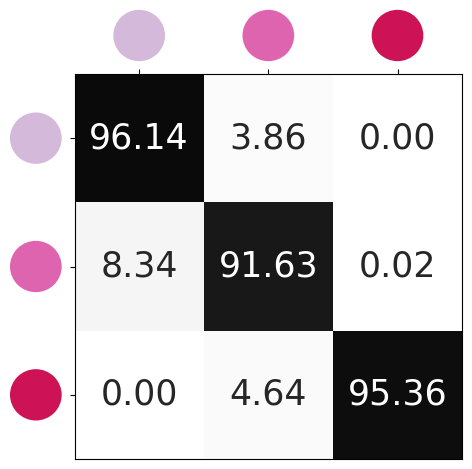

In [120]:
classifications = SOAPclassification(
    [], prepareData(classifiedFilteredLENS), [f"C{int(m[0])}" for m in np.sort(minmax, axis=0)]
)
tmat = calculateTransitionMatrix(classifications)
tmat = normalizeMatrixByRow(tmat)*100
_, ax = plt.subplots(1, figsize=(5,5))
heatmap(
    tmat,
    fmt='.2f',
    vmax=100,
    vmin=0,
    cmap="Greys",
    annot=True,
    annot_kws={"fontsize": 25},
    xticklabels=classifications.legend,
    yticklabels=classifications.legend,
    cbar=False,
    ax=ax,
)

for i, label in enumerate(classifications.legend):
    ax.add_patch(
        Circle(
            (0.5 + i, -0.3),
            facecolor=palette[i],
            lw=1.5,
            edgecolor=None,
            radius=0.2,
            clip_on=False,
        )
    )
    ax.add_patch(
        Circle(
            (-0.3, 0.5 + i),
            facecolor=palette[i],
            lw=1.5,
            edgecolor=None,
            radius=0.2,
            clip_on=False,
        )
    )

    for _, spine in ax.spines.items():
        spine.set_visible(True)

    ax.get_xaxis().set_ticklabels([])
    ax.xaxis.tick_top()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.savefig('mat_lens.svg')

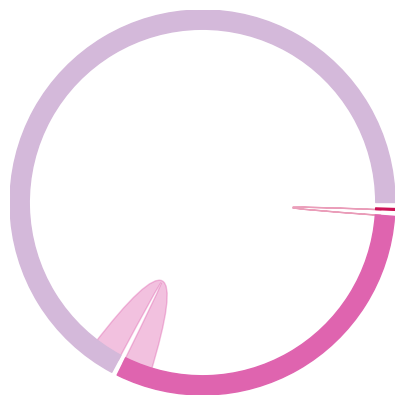

In [121]:
tmat = calculateTransitionMatrix(classifications)
fig, ax = plt.subplots(1, figsize=(5, 5))

ChordDiagram(
    tmat,
    ax=ax,
    colors=palette.as_hex(),
    # labels=["0", "1", "2", "3", "4"],
    # width=0,
    onlyFlux=True,
    #GAP=10,
    ignoreLessThan=0.01,
    ordering="matrix",
    labelskwargs=dict(),
    visualizationScale=1)
plt.savefig('chord.svg')


In [122]:
export(XYZ_OUTDIR+NAME+'LENS.xyz',  XYZ_DIR+HDF5_TRJ, windowToUSE_last, GROUP, XYZ_ORIG, classifiedFilteredLENS)

# JOINT descriptor

### Stack descriptros and reshape

In [123]:
v_soap_n = np.array(v_soap)
lens_tr = np.transpose(filteredLENS[:, windowToUSE])
np.shape(v_soap_n), np.shape(lens_tr)

((481, 900, 576), (481, 900))

In [124]:
joint_d = np.dstack((v_soap_n,np.expand_dims(lens_tr,-1)))
np.shape(joint_d)

(481, 900, 577)

In [125]:
np.shape(joint_d)
joint_d_fl = np.array(joint_d).reshape(np.shape(joint_d)[0]*np.shape(joint_d)[1],np.shape(joint_d)[2])
np.shape(joint_d_fl)

(432900, 577)

### PCA and clustering

In [126]:
pca = PCA(n_components=5)
pc_soap = pca.fit_transform(joint_d_fl)
pca.explained_variance_ratio_.cumsum()

array([0.75656672, 0.93439526, 0.98466951, 0.99452584, 0.99670161])

In [127]:
#r = np.random.RandomState(seed=1234)
#clusters_j = GaussianMixture(n_components=16, init_params='kmeans', tol=1e-9, max_iter=1000, random_state=r ).fit_predict(pc_soap)

In [128]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=80, cluster_selection_method='eom',prediction_data=True)
clusterer.fit(pc_soap)
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
clusters_j = np.array([np.argmax(x) for x in soft_clusters])

In [129]:
data_cl = {}
for i in range(np.max(clusters_j)+1):
    data_cl[i] = {}
    data_cl[i]["elements"] = pc_soap[clusters_j == i]
    data_cl[i]["min"] = np.min(data_cl[i]["elements"])
    data_cl[i]["max"] = np.max(data_cl[i]["elements"])

In [130]:
palette = sns.color_palette('tab20', n_colors=np.max(clusters_j)+1)
cluster_colors = [palette[x] for x in clusters_j]
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)]

/users_home/mcrippa/Joint_SOAP/functions_new.py:73: RuntimeWarning: divide by zero encountered in log
  lh = numpy.log(h)


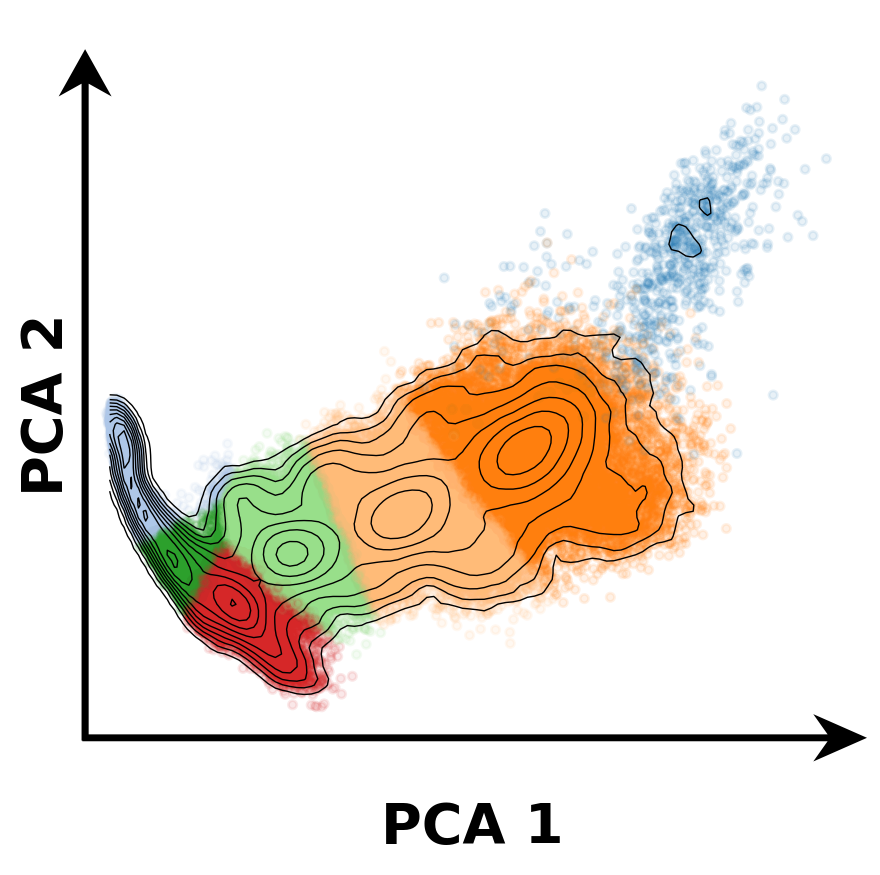

In [131]:
Xpc = 0
Ypc = 1

_, ax = plt.subplots(1, figsize=(5,5), dpi=200)

ax.scatter(pc_soap[:,Xpc],pc_soap[:,Ypc], c=np.array(palette)[clusters_j], marker='.', alpha=0.1)
lh, Xe, Ye, lhmin = getDensity(pc_soap, Xpc, Ypc, 100)
levels = 10
cont = ax.contour(Xe,
    Ye,
    lh,
    colors="k",
    linewidths=0.5,
    levels=levels,
    antialiased=True,
    linestyles="solid",
    vmin=lhmin,
    vmax=0,
)

ax.set_xlim((-0.1,0.4))

for side in ['bottom','right','top','left']:
    ax.spines[side].set_linewidth(2)


ax.set_xlabel('PCA 1', weight='bold',size=20)
ax.set_ylabel('PCA 2', weight='bold',size=20)
for side in ['right','top','left','bottom']:
    ax.spines[side].set_visible(False)

ax.tick_params(
axis='both',          # changes apply to the x-axis
which='major',      # both major and minor ticks are affected
bottom=False,
left=False,      
labelleft=False,
labelbottom=False) 
annots = arrowed_spines(ax, locations=('bottom right', 'left up')) 

In [132]:
reshaped_labels = prepareData(clusters_j.reshape(np.shape(joint_d)[0],np.shape(joint_d)[1]))
export(XYZ_OUTDIR+NAME+'JOINT.xyz',  XYZ_DIR+HDF5_TRJ, windowToUSE_last, GROUP, XYZ_ORIG, reshaped_labels)

### Transition matrix


In [133]:
minmax = [[cname, data["max"]] for cname, data in data_cl.items()]
minmax = sorted(minmax, key=lambda x: x[1])

In [151]:
order = {   0 : 1,
            1 : 4,
            2 : 6,
            3 : 5,
            4 : 3,
            5 : 2,
            6 : 0}

palette = sns.color_palette('tab20', n_colors=np.max(list(np.squeeze(clusters_j)))+1)
palette_s = list()
for i,v in enumerate(list(order.values())):
    palette_s.append(palette[v])

palette = sns.color_palette(palette_s)

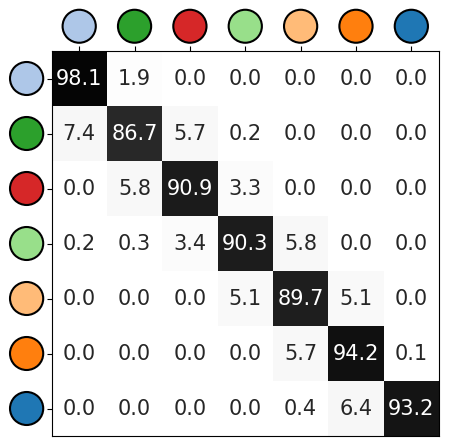

In [152]:
classifications = SOAPclassification(
    [], prepareData(reshaped_labels), [f"C{int(m[0])}" for m in np.sort(minmax, axis=0)]
)
tmat = calculateTransitionMatrix(classifications)
tmat = normalizeMatrixByRow(tmat)*100
tmat = tmat[:, list(order.values())]
tmat = tmat[ list(order.values()),:]

_, ax = plt.subplots(1,figsize=(5,5))
heatmap(
    tmat,
    fmt='.1f',
    vmax=100,
    vmin=0,
    cmap="Greys",
    annot=True,
    annot_kws={"fontsize": 15},
    xticklabels=classifications.legend,
    yticklabels=classifications.legend,
    cbar=False,
    ax=ax,
)

for i, label in enumerate(classifications.legend):
    ax.add_patch(
        Circle(
            (0.5 + i, -0.45),
            facecolor=palette[i],
            lw=1.5,
            edgecolor='black',
            radius=0.3,
            clip_on=False,
        )
    )
    ax.add_patch(
        Circle(
            (-0.45, 0.5 + i),
            facecolor=palette[i],
            lw=1.5,
            edgecolor='black',
            radius=0.3,
            clip_on=False,
        )
    )

    for _, spine in ax.spines.items():
        spine.set_visible(True)

    ax.get_xaxis().set_ticklabels([])
    ax.xaxis.tick_top()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.savefig("mat.svg")


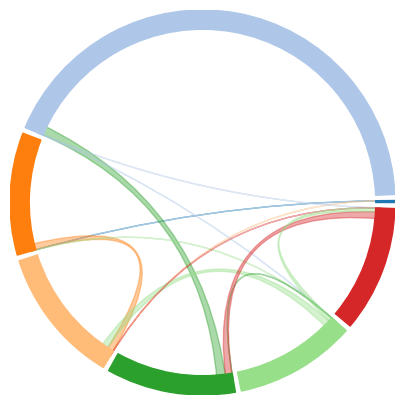

In [135]:
tmat = calculateTransitionMatrix(classifications)
fig, ax = plt.subplots(1, figsize=(5, 5))

ChordDiagram(
    tmat,
    ax=ax,
    colors=palette.as_hex(),
    # labels=["0", "1", "2", "3", "4"],
    # width=0,
    onlyFlux=True,
    #GAP=10,
    ignoreLessThan=0.1,
    ordering="weight",
    labelskwargs=dict(),
    visualizationScale=1)
plt.savefig('chord.svg')

/tmp/ipykernel_2062760/1795647127.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels("1", fontsize=15)


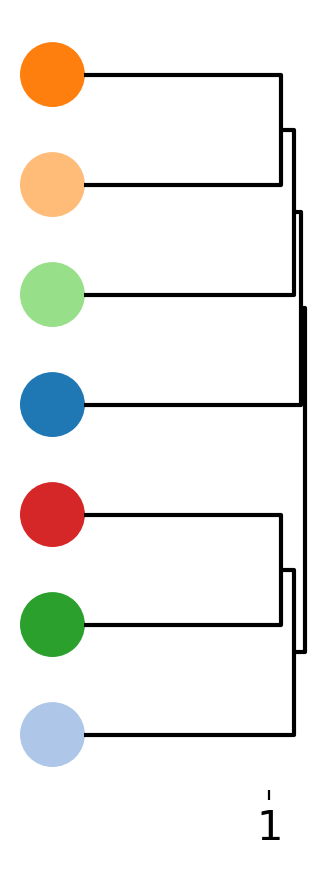

In [159]:
cM = pdist(tmat, 'correlation')
Z = linkage(cM, method='average')
fig, ax = plt.subplots(figsize=(1.5, 5), dpi=200)
dn = dendrogram(Z,orientation='right',distance_sort='ascending', color_threshold=0, above_threshold_color='black', ax=ax)


TICKYPOS = -0.17
tickslabels = [i*10+5 for i in range(len(tmat))]

for i in range(len(tmat)):
    ax.add_patch(patches.Ellipse((TICKYPOS,tickslabels[i]), 0.35,5.9, facecolor=palette[dn['leaves'][i]], lw=1,
                  edgecolor=None, clip_on=False))


#ax.set_xticklabels([])
ax.set_yticklabels([])
_ = ax.set_xticklabels("1", fontsize=15)
_ = ax.set_xticks([1])
for _, spine in ax.spines.items():
    spine.set_visible(False)
plt.savefig('dendro.svg')

### Dendrogram

In [137]:
mapping = { 0 : [0],
            2 : [3],
            3 : [1],
            1 : [2],
            4 : [5],
            5 : [4],
            6 : [6]}

In [138]:
#mapping = { 0 : [0],
#            2 : [1,2,3,4,5,6]}

In [139]:
new_dic = {}
for k,v in mapping.items():
    for x in v:
        new_dic.setdefault(x,[]).append(k)

In [140]:
replacer = new_dic.get  # For faster gets.
clusters_j_dn =  np.squeeze(np.array([replacer(n, n) for n in clusters_j]))
palette = sns.color_palette('turbo',n_colors=np.max(list(np.squeeze(clusters_j_dn))))
palette = ['magenta', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray']#+palette
#palette = ['magenta']+palette
cluster_colors = [palette[x] for x in list(np.squeeze(clusters_j_dn))]
palette = sns.color_palette(palette)
palette

[(1.0, 0.0, 1.0),
 (0.5019607843137255, 0.5019607843137255, 0.5019607843137255),
 (0.5019607843137255, 0.5019607843137255, 0.5019607843137255),
 (0.5019607843137255, 0.5019607843137255, 0.5019607843137255),
 (0.5019607843137255, 0.5019607843137255, 0.5019607843137255),
 (0.5019607843137255, 0.5019607843137255, 0.5019607843137255),
 (0.5019607843137255, 0.5019607843137255, 0.5019607843137255)]

In [222]:
sel_p = [54]
#sel_p =[]
trj_nframe = 481

(-0.1721425382215797, 0.3356265130498604)


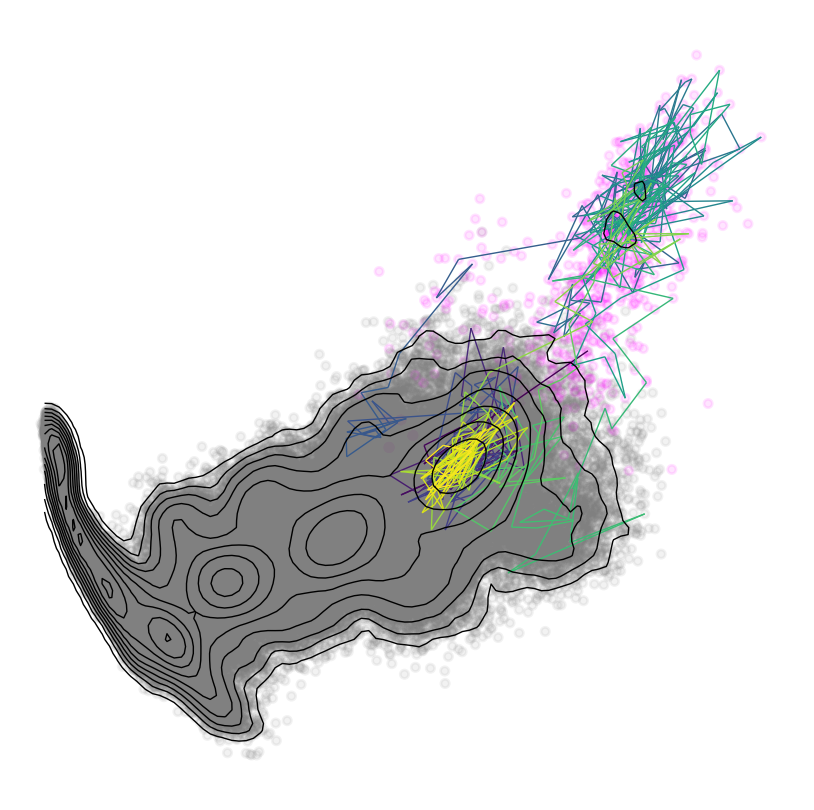

In [225]:
Xpc = 0
Ypc = 1

_, ax = plt.subplots(1, figsize=(5,5), dpi=200)

ax.scatter(pc_soap[:,Xpc],pc_soap[:,Ypc], c=np.array(palette)[clusters_j_dn], marker='.', alpha=0.1)
dydx = np.array([i for i in range(trj_nframe)])

for p in sel_p:
    x = pc_soap[p:-1:nAtoms,Xpc]
    y = pc_soap[p:-1:nAtoms,Ypc]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(dydx.min(), dydx.max())
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    lc.set_array(dydx)
    lc.set_linewidth(0.5)
    line = ax.add_collection(lc)

lh, Xe, Ye, lhmin = getDensity(pc_soap, Xpc, Ypc, 100)
levels = 10
cont = ax.contour(Xe,
    Ye,
    lh,
    colors="k",
    linewidths=0.5,
    levels=levels,
    antialiased=True,
    linestyles="solid",
    vmin=lhmin,
    vmax=0,
)

ax.set_xlim((-0.1,0.4))
print(ax.get_ylim())
for side in ['bottom','right','top','left']:
    ax.spines[side].set_linewidth(2)


#ax.set_xlabel('PCA 1', weight='bold',size=20)
#ax.set_ylabel('PCA 2', weight='bold',size=20)
for side in ['right','top','left','bottom']:
    ax.spines[side].set_visible(False)

ax.tick_params(
axis='both',          # changes apply to the x-axis
which='major',      # both major and minor ticks are affected
bottom=False,
left=False,      
labelleft=False,
labelbottom=False) 
#annots = arrowed_spines(ax, locations=('bottom right', 'left up')) 

In [224]:
reshaped_labels = prepareData(clusters_j_dn.reshape(np.shape(joint_d)[0],np.shape(joint_d)[1]))
export(XYZ_OUTDIR+NAME+'JOINT_macro.xyz',  XYZ_DIR+HDF5_TRJ, windowToUSE_last, GROUP, XYZ_ORIG, reshaped_labels)

In [157]:
data_cl = {}
for i in range(np.max(clusters_j_dn)+1):
    data_cl[i] = {}
    data_cl[i]["elements"] = pc_soap[clusters_j_dn == i]
    data_cl[i]["min"] = np.min(data_cl[i]["elements"])
    data_cl[i]["max"] = np.max(data_cl[i]["elements"])

In [158]:
minmax = [[cname, data["max"]] for cname, data in data_cl.items()]
minmax = sorted(minmax, key=lambda x: x[1])

In [168]:
order = {   0 : 3,
            1 : 5,
            2 : 6,
            3 : 4,
            4 : 2,
            5 : 1,
            6 : 0}

palette = sns.color_palette('turbo',n_colors=np.max(list(np.squeeze(clusters_j_dn))))
palette = ['magenta']+palette
palette_s = list()
for i,v in enumerate(list(order.values())):
    palette_s.append(palette[v])

palette = sns.color_palette(palette_s)

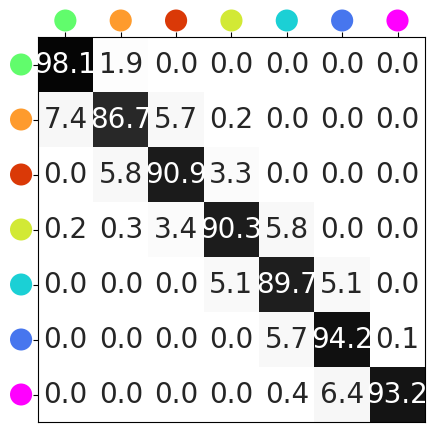

In [170]:
classifications = SOAPclassification(
    [], prepareData(reshaped_labels), [f"C{int(m[0])}" for m in np.sort(minmax, axis=0)]
)

tmat = calculateTransitionMatrix(classifications)
tmat = normalizeMatrixByRow(tmat)*100
tmat = tmat[:, list(order.values())]
tmat = tmat[ list(order.values()),:]

_, ax = plt.subplots(1, figsize=(5,5))
heatmap(
    tmat,
    fmt='.1f',
    vmax=100,
    vmin=0,
    cmap="Greys",
    annot=True,
    annot_kws={"fontsize": 20},
    xticklabels=classifications.legend,
    yticklabels=classifications.legend,
    cbar=False,
    ax=ax,
)

for i, label in enumerate(classifications.legend):
    ax.add_patch(
        Circle(
            (0.5 + i, -0.3),
            facecolor=palette[i],
            lw=1.5,
            edgecolor=None,
            radius=0.2,
            clip_on=False,
        )
    )
    ax.add_patch(
        Circle(
            (-0.3, 0.5 + i),
            facecolor=palette[i],
            lw=1.5,
            edgecolor=None,
            radius=0.2,
            clip_on=False,
        )
    )

    for _, spine in ax.spines.items():
        spine.set_visible(True)

    ax.get_xaxis().set_ticklabels([])
    ax.xaxis.tick_top()
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.savefig("mat.svg")


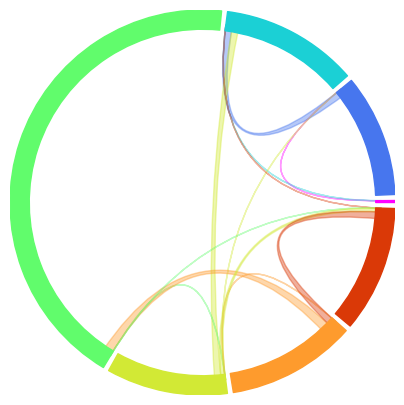

In [173]:
palette = sns.color_palette('turbo',n_colors=np.max(list(np.squeeze(clusters_j_dn))))
palette = ['magenta']+palette
tmat = calculateTransitionMatrix(classifications)
fig, ax = plt.subplots(1, figsize=(5, 5))

ChordDiagram(
    tmat,
    ax=ax,
    colors=palette,
    # labels=["0", "1", "2", "3", "4"],
    # width=0,
    onlyFlux=True,
    #GAP=10,
    ignoreLessThan=0.1,
    ordering="weight",
    labelskwargs=dict(),
    visualizationScale=1)
plt.savefig('chord.svg')